# XGBoost 회귀 하이퍼 파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기


In [9]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.regression import *

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기


In [10]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)


상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX |   PTRATIO |      B |   LSTAT |   MEDV |
|----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------|
|  0 | 0.00632 |   18 |    2.31 |      0 | 0.538 | 6.575 |  65.2 |   4.09 |     1 |   296 |      15.3 |  396.9 |    4.98 |     24 |
|  1 | 0.02731 |    0 |    7.07 |      0 | 0.469 | 6.421 |  78.9 | 4.9671 |     2 |   242 |      17.8 |  396.9 |    9.14 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 |      0 | 0.469 | 7.185 |  61.1 | 4.9671 |     2 |   242 |      17.8 | 392.83 |    4.03 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 |      0 | 0.458 | 6.998 |  45.8 | 6.0622 |     3 |   222 |      18.7 | 394.63 |    2.94 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 |      0 | 0.458 | 7.147 |  54.2 | 

### [3] 훈련/검증 데이터 분할 및 데이터 표준화


In [11]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, "MEDV", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

## #02. XGBoost 학습 모델 적합

### [1] 하이퍼 파라미터 튜닝


In [12]:
%%time

estimator = XGBRegressor(
    # general params
    booster="gbtree",
    device="cpu",
    verbosity=0,
    n_jobs=get_n_jobs(),
    # train parameter
    objective="reg:squarederror",
    eval_metric="rmse",
    early_stopping_rounds=10,
    # booster params
    random_state = get_random_state()
)

params = {
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 1],
    "n_estimators": [100, 200, 300, 400, 500],
    "min_child_weight": [1, 3, 5, 7, 9],
    "gamma": [0, 1, 2, 3, 4, 5],
    "max_depth": [0, 2, 4, 6],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "reg_alpha": [1, 3, 5, 7, 9],
    "reg_lambda": [1, 3, 5, 7, 9]
}

estimator = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_iter=get_max_iter(),
    n_jobs=get_n_jobs(),
    cv=5,
    verbose=0
)

estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)

CPU times: total: 6.8 s
Wall time: 39.6 s


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device='cpu',
                                          early_stopping_rounds=10,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_...
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=0, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 1, 2, 3, 4, 5],
                                        'learning_rate': [0.1, 0.3, 0.5, 0.7,
                                                          1],
                                        'max_depth': [0, 2, 4, 6],
                                        'min_child_weight': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [1, 3, 5, 7, 9],
                                        'reg_lambda': [1, 3, 5, 7, 9],
                                        'subsample': [0.5, 0.7, 1]})

### [2] RandomizedSearchCV 결과 확인


In [13]:
result_df = DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)

my_pretty_table(result_df.head(10))

+----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------+
|    |   subsample |   reg_lambda |   reg_alpha |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   gamma |   colsample_bytree |   mean_test_score |
|----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------|
|  0 |         0.7 |            7 |           1 |            300 |                  9 |           4 |             0.3 |       2 |                0.7 |          0.887995 |
|  1 |           1 |            7 |           1 |            400 |                  1 |           4 |             0.1 |       0 |                0.8 |          0.886844 |
|  2 |         0.5 |            9 |           1 |            400 |                  9 |           0 |             0.1 |       5 |                

### [2] 성능 평가


[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.983871 |     0.761761 |
| 평균절대오차(MAE)             |      0.87774 |      2.79444 |
| 평균제곱오차(MSE)             |      1.37327 |      19.3995 |
| 평균오차(RMSE)                |      1.17187 |      4.40448 |
| 평균 절대 백분오차 비율(MAPE) |      4.56047 |      13.2742 |
| 평균 비율 오차(MPE)           |    -0.663183 |     -2.72806 |
+-------------------------------+--------------+--------------+

[학습곡선]


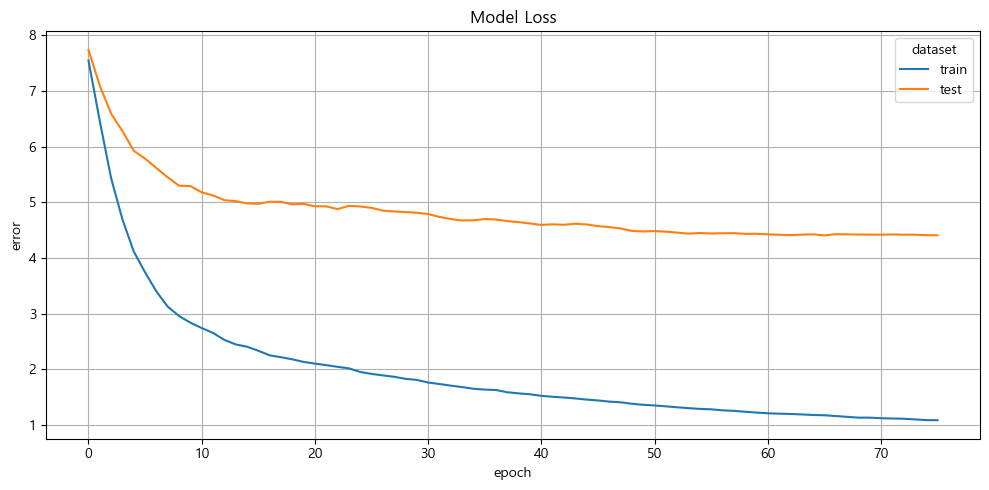


[변수 중요도]


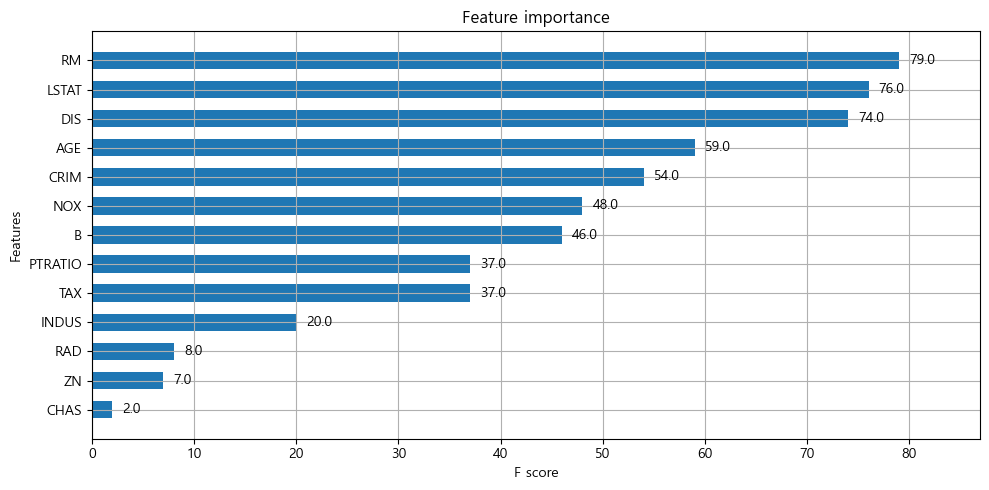

+---------+---------+------------+----------+
|         |   score |       rate |   cumsum |
|---------+---------+------------+----------|
| RM      |      79 |   0.144424 | 0.144424 |
| LSTAT   |      76 |    0.13894 | 0.283364 |
| DIS     |      74 |   0.135283 | 0.418647 |
| AGE     |      59 |   0.107861 | 0.526508 |
| CRIM    |      54 |  0.0987203 | 0.625229 |
| NOX     |      48 |  0.0877514 |  0.71298 |
| B       |      46 |  0.0840951 | 0.797075 |
| TAX     |      37 |  0.0676417 | 0.864717 |
| PTRATIO |      37 |  0.0676417 | 0.932358 |
| INDUS   |      20 |  0.0365631 | 0.968921 |
| RAD     |       8 |  0.0146252 | 0.983547 |
| ZN      |       7 |  0.0127971 | 0.996344 |
| CHAS    |       2 | 0.00365631 |        1 |
+---------+---------+------------+----------+
+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV

In [14]:
my_regression_result(estimator.best_estimator_, x_train, y_train, x_test, y_test)
my_regression_report(estimator.best_estimator_, x_train, y_train, x_test, y_test)

## #03. 모듈화 기능 확인


[교차검증 TOP5]
+----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------+
|    |   subsample |   reg_lambda |   reg_alpha |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   gamma |   colsample_bytree |   mean_test_score |
|----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------|
|  0 |         0.7 |            5 |           7 |            300 |                  9 |           4 |             0.1 |       3 |                0.6 |          0.878838 |
|  1 |           1 |            7 |           1 |            200 |                  1 |           6 |             0.1 |       2 |                0.7 |          0.873729 |
|  2 |         0.5 |            9 |           1 |            100 |                  3 |           4 |             0.1 |       2 |    

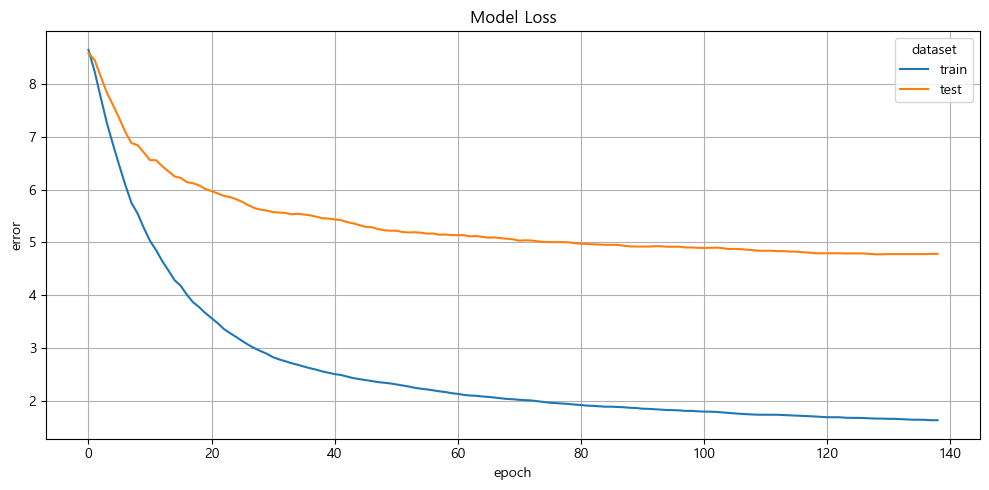


[변수 중요도]


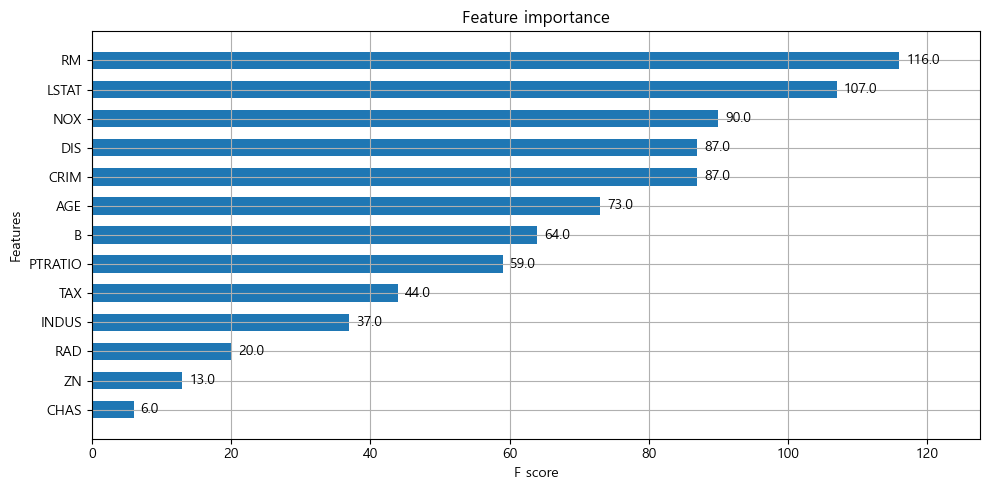

+---------+---------+------------+----------+
|         |   score |       rate |   cumsum |
|---------+---------+------------+----------|
| RM      |     116 |   0.144458 | 0.144458 |
| LSTAT   |     107 |    0.13325 | 0.277709 |
| NOX     |      90 |    0.11208 | 0.389788 |
| CRIM    |      87 |   0.108344 | 0.498132 |
| DIS     |      87 |   0.108344 | 0.606476 |
| AGE     |      73 |  0.0909091 | 0.697385 |
| B       |      64 |  0.0797011 | 0.777086 |
| PTRATIO |      59 |  0.0734745 |  0.85056 |
| TAX     |      44 |  0.0547945 | 0.905355 |
| INDUS   |      37 |  0.0460772 | 0.951432 |
| RAD     |      20 |  0.0249066 | 0.976339 |
| ZN      |      13 |  0.0161893 | 0.992528 |
| CHAS    |       6 | 0.00747198 |        1 |
+---------+---------+------------+----------+

+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MED

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device='cpu', early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
%%time
my_xgb_regression(x_train, y_train, x_test, y_test)

In [16]:
my_trace()

Edge cannot be created because at least one of the nodes is None: node_a: None, node_b: "hossam.util.my_pretty_table" [fillcolor="#b8d3a8", label="hossam.util.my_pretty_table\nNumber of Calls: 8\n10.65 ms"];
